In [71]:
from nemo.collections.tts.models import TalkNetDursModel
from nemo.collections.tts.models import TalkNetSpectModel

pretrained_model_durs = "./dn2.ckpt"
pretrained_model_spec = "./sn2.ckpt"

dn = TalkNetDursModel.load_from_checkpoint(checkpoint_path=pretrained_model_durs)

sn = TalkNetSpectModel.load_from_checkpoint(checkpoint_path=pretrained_model_spec)


[NeMo W 2020-10-02 09:38:12 modelPT:101] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      cls: nemo.collections.asr.data.audio_to_text.AudioToCharWithDursDataset
      params:
        manifest_filepath: /home/iglabutin/work/data/sets/ljspeech/LJSpeech-1.1/ljspeech_train.json
        max_duration: null
        min_duration: 0.1
        int_values: false
        load_audio: false
        normalize: false
        sample_rate: 22050
        trim: false
        vocab_notation: phonemes
        vocab_punct: true
        vocab_spaces: true
        vocab_stresses: false
        durs_path: /home/iglabutin/work/data/sets/ljspeech/nemo/durs/phonemes/punct-T_stresses-F_spaces-T.pth
        rep: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2020-10-02 09:38:12 modelPT:108] Please call the ModelPT.setup_vali

[NeMo I 2020-10-02 09:38:12 features:241] PADDING: 1
[NeMo I 2020-10-02 09:38:12 features:254] STFT using conv


In [72]:
text_to_generate = input("Input what you want the model to say: ")

Input what you want the model to say: hello world


In [73]:
tokens = sn.parse(text_to_generate)
tokens = tokens.reshape(1, -1)
print(tokens)


tensor([[ 7, 27, 10, 36,  0, 21, 32, 10,  3]])


In [75]:
#import sys
#sys.path.insert(1, '/home/iglabutin/NeMo/nemo/utils/')
#print(sys.path)

import talknet_utils
# from nemo.utils import talknet_utils

import torch

tokens_len = torch.tensor(len(tokens))
tokens_with_blanks, tokens_len = talknet_utils.interleave(tokens, tokens_len, dn.vocab)
print(tokens_with_blanks)

tensor([[57,  7, 57, 27, 57, 10, 57, 36, 57,  0, 57, 21, 57, 32, 57, 10, 57,  3,
         57]])


In [76]:
#old version

#import torch

#tokens_with_blanks = dn.vocab.blank * torch.ones(2 * tokens.shape[0] + 1, dtype=torch.int64)

#for i in range(tokens.shape[0]):
#    tokens_with_blanks[2 * i + 1] = tokens[i]

#tokens_with_blanks = tokens_with_blanks.reshape(1, -1)
#print(tokens_with_blanks)

#print(tokens_with_blanks.shape)

In [77]:
durs_log = dn.forward(text=tokens_with_blanks, text_len=torch.tensor([1]))

print(durs_log)

tensor([[0.6173, 1.5615, 1.5890, 1.5658, 1.5985, 1.5573, 1.5870, 1.5929, 1.5396,
         1.5949, 1.5840, 1.5472, 1.5906, 1.5585, 1.5823, 1.5988, 1.5649, 1.5825,
         1.5809]], grad_fn=<SqueezeBackward1>)


In [78]:
durs = (durs_log.exp() + 1).long()
print(durs)
print(durs.sum())

tensor([[2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]])
tensor(92)


In [79]:
tokens_expanded, tokens_len = talknet_utils.repeat_interleave(tokens_with_blanks, durs)
print(tokens_expanded, tokens_len)

tensor([[57, 57,  7,  7,  7,  7,  7, 57, 57, 57, 57, 57, 27, 27, 27, 27, 27, 57,
         57, 57, 57, 57, 10, 10, 10, 10, 10, 57, 57, 57, 57, 57, 36, 36, 36, 36,
         36, 57, 57, 57, 57, 57,  0,  0,  0,  0,  0, 57, 57, 57, 57, 57, 21, 21,
         21, 21, 21, 57, 57, 57, 57, 57, 32, 32, 32, 32, 32, 57, 57, 57, 57, 57,
         10, 10, 10, 10, 10, 57, 57, 57, 57, 57,  3,  3,  3,  3,  3, 57, 57, 57,
         57, 57]]) tensor([92])


In [80]:
#old version

#tokens_expanded = torch.zeros(durs.sum(), dtype=torch.int64)
#print(tokens_expanded.shape)
#k = 0
#for i in range(durs.shape[1]):
#    for j in range(durs[0, i]):
#        tokens_expanded[k] = tokens_with_blanks[0, i]
#        k += 1

#tokens_expanded = tokens_expanded.reshape(1, -1)
#print(tokens_expanded)

In [81]:
spectrogram = sn.forward(text=tokens_expanded, text_len=torch.tensor([1])).cuda()
print(spectrogram)

tensor([[[-19.9951,  -5.6969,  -5.7776,  ...,  -5.8143,  -5.8458,  -5.7834],
         [-16.1655,  -5.0499,  -5.1200,  ...,  -5.1428,  -5.1494,  -5.0993],
         [-14.5775,  -4.1360,  -4.2144,  ...,  -4.1791,  -4.1754,  -4.1416],
         ...,
         [ -9.7965,  -5.6717,  -5.7297,  ...,  -5.6980,  -5.7914,  -5.6719],
         [-10.3100,  -5.6268,  -5.6754,  ...,  -5.6498,  -5.7465,  -5.6158],
         [-11.1609,  -5.6650,  -5.6955,  ...,  -5.6567,  -5.7541,  -5.6476]]],
       device='cuda:0', grad_fn=<CopyBackwards>)


In [82]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [83]:
supported_audio_gen = ["griffin_lim", "waveglow", "squeezewave"]

print("Choose one of the following audio generators:")
print([model for model in supported_audio_gen])
audio_generator = input()

assert audio_generator in supported_audio_gen

Choose one of the following audio generators:
['griffin_lim', 'waveglow', 'squeezewave']
waveglow


In [84]:
from omegaconf import OmegaConf, open_dict
import torch
from ruamel.yaml import YAML
from nemo.collections.asr.parts import parsers

SAMPLE_RATE = 22050
NFFT = 1024
NMEL = 80
FMAX = None

def load_vocoder_model():
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel as VocoderModel
        pretrained_model = "WaveGlow-22050Hz"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel as VocoderModel
        pretrained_model = "SqueezeWave-22050Hz"
    elif audio_generator == "griffin_lim":
        from nemo.collections.tts.helpers.helpers import griffin_lim
        import numpy as np
        import librosa
        class GL:
            def __init__(self):
                pass
            def convert_spectrogram_to_audio(self, spec):
                log_mel_spec = spec.squeeze().to('cpu').numpy().T
                mel_spec = np.exp(log_mel_spec)
                mel_pseudo_inverse = librosa.filters.mel(SAMPLE_RATE, NFFT, NMEL, fmax=FMAX)
                return griffin_lim(np.dot(mel_spec, mel_pseudo_inverse).T ** 1.2)
            def load_state_dict(self, *args, **kwargs):
                pass
            def cuda(self, *args, **kwargs):
                return self
        return GL()
    else:
        raise NotImplementedError

    model = VocoderModel.from_pretrained(pretrained_model)
    with open_dict(model._cfg):
        global SAMPLE_RATE
        global NFFT
        global NMEL
        global FMAX
        if model._cfg.sample_rate is not None and SAMPLE_RATE is not None:
            assert model._cfg.sample_rate == SAMPLE_RATE
        if model._cfg.n_fft is not None and NFFT is not None:
            assert _cfg.n_fft == NFFT
        if model._cfg.n_mels is not None and NMEL is not None:
            assert model._cfg.n_mels == NMEL
        if model._cfg.fmax is not None and FMAX is not None:
            assert model._cfg.fmax == FMAX
    return model

vocoder = load_vocoder_model().cuda()

[NeMo I 2020-10-02 09:38:59 cloud:55] Found existing object /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo.
[NeMo I 2020-10-02 09:38:59 cloud:61] Re-using file from: /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo
[NeMo I 2020-10-02 09:38:59 common:394] Instantiating model from pre-trained checkpoint
[NeMo I 2020-10-02 09:39:05 features:241] PADDING: 16
[NeMo I 2020-10-02 09:39:05 features:254] STFT using conv
[NeMo I 2020-10-02 09:39:07 modelPT:237] Model WaveGlowModel was successfully restored from /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo.


In [85]:
with torch.no_grad():
    audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()

In [86]:
if isinstance(spectrogram, torch.Tensor):
    spectrogram = spectrogram.to('cpu').detach().numpy()
if len(spectrogram.shape) == 3:
    spectrogram = spectrogram[0]

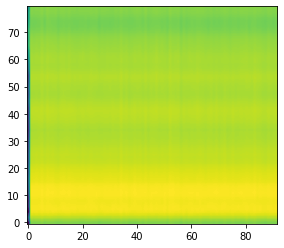

In [87]:
%matplotlib inline
imshow(spectrogram, origin="lower")
plt.show()

In [88]:
if isinstance(audio, torch.Tensor):
    audio = audio.to('cpu').numpy()
ipd.Audio(audio, rate=SAMPLE_RATE)